# 7. DQN算法

## 7.1 简介
- 在第 5 章讲解的 Q-learning 算法中，我们以矩阵的方式建立了一张存储每个状态下所有动作 $Q$ 值的表格。表格中的每一个动作价值 $Q(s,a)$ 表示在状态 $s$ 下选择动作 $a$ 然后继续遵循某一策略预期能够得到的期望回报。然而，这种用表格存储动作价值的做法只在环境的状态和动作都是离散的，并且空间都比较小的情况下适用，我们之前进行代码实战的几个环境都是如此（如悬崖漫步）。当状态或者动作数量非常大的时候，这种做法就不适用了。例如，当状态是一张 RGB 图像时，假设图像大小是 $210 \times 160 \times 3$，此时一共有 $256^{(210 \times 60 \times 3)}$ 种状态，在计算机中存储这个数量级的 $Q$ 值表格是不现实的。更甚者，当状态或者动作连续的时候，就有无限个状态动作对，我们更加无法使用这种表格形式来记录各个状态动作对的 $Q$ 值。

- 对于这种情况，我们需要函数拟合方式来估计 $Q$ 值，即将这个复杂 $Q$ 值表格视作数据，使用一个参数化的函数 $Q_{\theta}$ 来拟合这些数据。很显然，这种函数拟合的方法存在一定的精度损失，因此被称为近似方法。我们今天要介绍的 DQN 算法便可以用来解决连续状态下离散动作的问题。

## 7.2 CartPole 环境
- 以图 7-1 中所示的所示的车杆（CartPole）环境为例，它的状态值就是连续的，动作值是离散的。

<div align="center">
    <img src="./image/7-1.gif">
    <center>图 7-1 CartPole环境示意图</center>
</div> 

- 在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直，若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达 200 帧，则游戏结束。智能体的状态是一个维数为 4 的向量，每一维都是连续的，其动作是离散的，动作空间大小为 2，详情参见表 7-1 和表 7-2。在游戏中每坚持一帧，智能体能获得分数为 1 的奖励，坚持时间越长，则最后的分数越高，坚持 200 帧即可获得最高的分数。


<center>表 7-1 CartPole 环境的状态空间</center>

| 维度 | 意义             | 最小值   | 最大值   |
| ---- | ---------------- | -------- | -------- |
| 0    | 车的位置         | -2.4     | 2.4      |
| 1    | 车的速度         | -Inf     | Inf      |
| 2    | 杆的角度         | ~-41.8°  | ~41.8°   |
| 3    | 杆尖端的速度     | -Inf     | Inf      |

---

<center>表 7-2 CartPole 环境的动作空间</center>

| 标号 | 动作           |
| ---- | -------------- |
| 0    | 向左移动小车   |
| 1    | 向右移动小车   |


## 7.3 DQN
- 现在我们想在类似车杆的环境中得到动作价值函数 $Q(s,a)$，由于状态每一维度的值都是连续的，无法使用表格记录，因此一个常见的解决方法便是使用**函数拟合**（function approximation）的思想。由于神经网络具有强大的表达能力，因此我们可以用一个神经网络来表示函数 $Q$。若动作是连续（无限）的，神经网络的输入是状态 $s$ 和动作 $a$，然后输出一个标量，表示在状态 $s$ 下采取动作 $a$ 能获得的价值。若动作是离散（有限）的，除了可以采取动作连续情况下的做法，我们还可以只将状态 $s$ 输入到神经网络中，使其同时输出每一个动作的 $Q$ 值，通常 DQN （以及 Q-learning）只能处理动作离散的情况，因为在函数 $Q$ 的更新过程中有 $\max_a$ 这一操作。假设神经网络用来拟合函数的参数是 $\omega$，即每一个状态 $s$ 下所有可能动作 $a$ 的 $Q$ 值我们都能表示为：$Q_{\omega}(s,a)$。我们将用于拟合函数 $Q$ 的神经网络称为 **$Q$ 网络**，如图 7-2 所示。

<div align="center">
    <img src="./image/7-2.png">
    <center>图 7-2 工作在CartPole环境中的Q网络示意图</center>
</div> 

- 那么 Q 网络的损失函数是什么呢？我们先来回顾一下 Q-learning 的更新规则（参见 5.5 节）：

$$
Q(s,a)\leftarrow Q(s,a)+\alpha\left[r+\gamma\max_{a^{\prime}\in\mathcal{A}}Q(s^{\prime},a^{\prime})-Q(s,a)\right]
$$

- 上述公式用**时序差分**（temporal difference，TD）学习目标 $r + \gamma \max_{a' \in \mathcal{A}}Q(s',a')$ 来增量式更新 $Q(s,a)$，也就是说要使 $Q(s,a)$ 和 TD 目标 $r + \gamma \max_{a' \in \mathcal{A}}Q(s',a')$ 靠近。于是，对于一组数据 $\\{(s_i, a_i, r_i, s_i')\\}$，我们可以很自然地将 Q 网络的损失函数构造为均方误差的形式：

$$
\omega^*=\arg\min_\omega\frac{1}{2N}\sum_{i=1}^N\left[Q_\omega\left(s_i,a_i\right)-\left(r_i+\gamma\max_{a^{\prime}}Q_\omega\left(s_i^{\prime},a^{\prime}\right)\right)\right]^2
$$

- 至此，我们就可以将 Q-learning 扩展到神经网络形式 - 深度 Q 网络（Deep Q Network，DQN）算法。由于 DQN 是离线策略算法，因此我们在收集数据的时候可以使用一个 $\epsilon$-贪婪策略来平衡探索与利用，将收集到的数据存储起来，在后续的训练中使用。DQN 中还有两个非常重要的模块——**经验回放**和**目标网络**，他们能够帮助 DQN 取得稳定、出色的性能。

### 7.3.1 经验回放
- 在一般的有监督学习中，在一般的有监督学习中，假设训练数据是独立同分布的，我们每次训练神经网络的时候从训练数据中随机采样一个或若干个数据来进行梯度下降，随着学习的不断进行，每一个训练数据会被使用多次。在原来的 Q-learning 算法中，每一个数据只会用来更新一次 $Q$ 值。为了更好地将 $Q-learning$ 和深度神经网络结合，DQN 算法采用了**经验回放**（experience replay）方法，具体做法为维护一个**回放缓冲区**，将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练。这么做可以起到以下两个作用。
    - 使样本满足独立假设。在 MDP 中交互采样得到的数据本身不满足独立假设，因为这一时刻的状态和上一时刻的状态有关。非独立同分布的数据对训练神经网络有很大的影响，会使神经网络拟合到最近训练的数据上。采用经验回放可以打破样本之间的相关性，让其满足独立假设。
    - 提高样本效率。每一个样本可以被使用多次，十分适合深度神经网络的梯度学习。
    
### 7.3.2 目标网络
- DQN 算法最终更新的目标是让 $Q_{\omega}(s,a)$ 逼近 $r + \gamma \max_{a'}Q_{\omega}(s', a')$，由于 TD 误差目标本身就包含神经网络的输出，因此在更新网络参数的同时目标也在不断地改变，这非常容易造成神经网络训练的不稳定性。为了解决这一问题，DQN 便使用了**目标网络**（target network）的思想：既然训练过程中 Q 网络的不断更新会导致目标不断发生改变，不如暂时先将 TD 目标中的 Q 网络固定住。为了实现这一思想，我们需要利用两套 Q 网络。
    - 原来的训练网络 $Q_{\omega}(s,a)$，用于计算原来的损失函数 $\frac{1}{2}[Q_{\omega}\left(s,a\right)-\left(r+\gamma\max_{a^{\prime}}Q_{\omega^{-}}\left(s^{\prime},a^{\prime}\right)\right)]^{2}$ 中的 $Q_{\omega}(s,a)$ 项，并使用正常梯度下降方法来进行更新。
    - 目标网络 $Q_{\omega^-}(s,a)$，用于计算原先损失函数 $\frac{1}{2}[Q_{\omega}\left(s,a\right)-\left(r+\gamma\max_{a^{\prime}}Q_{\omega^{-}}\left(s^{\prime},a^{\prime}\right)\right)]^{2}$ 中的 $Q_{\omega}(s,a)$ 项，其中 $\omega^-$ 表示目标网络中的参数。如果两套网络的参数随时保持一致，则仍为原先不够稳定的算法。为了让更新目标更稳定，目标网络并不会每一步都会更新。具体而言，目标网络使用训练网络的一套较旧的参数，训练网络 $Q_{\omega}(s,a)$ 在训练中的每一步都会更新，而目标网络的参数每隔 $C$ 步才会与训练网络同步一次，即 $\omega^- \leftarrow \omega$。这样做使得目标网络相对于训练网络更加稳定。

- 综上所述，DQN 算法的具体流程如下：
    - 用随机的网络参数 $\omega$ 初始化网络 $Q_{\omega}(s,a)$
    - 复制相同的参数 $\omega^- \leftarrow \omega$ 来初始化目标网络 $Q_{\omega'}$
    - 初始化经验放回池 $R$
    - for 序列 $e = 1 \to E$ do:
        - 获取环境初始状态 $s_1$
        - for 时间步 $t = 1 \to T$ do:
            - 根据当前网络 $Q_{\omega}(s,a)$ 以 $\epsilon$-贪婪策略选择动作 $a_t$
            - 执行动作 $a_t$，获得汇报 $r_t$，环境状态变为 $s_{t+1}$
            - 将 $(s_t, a_t, r_t, s_{t + 1})$ 存储进回放池 $R$ 中
            - 若 $R$ 中数据足够，从 $R$ 中采样 $N$ 个数据 $\{(s_i, a_i, r_i, s_{i + 1})\}_{i = 1,\dots,N}$
            - 对每个数据，用目标网络计算 $y_i=r_i+\gamma\max_aQ_{\omega^-}(s_{i+1},a)$
            - 最小化目标损失 $L=\frac{1}{N}\sum_i(y_i-Q_\omega(s_i,a_i))^2$，以此更新当前网络 $Q_{\omega}$
            - 更新目标网络
        - end for
    - end for

## 7.4 DQN 代码实践
- 接下来，我们就正式进入 DQN 算法的代码实践环节。我们采用的测试环境是 CartPole-v0，其状态空间相对简单，只有 4 个变量，因此网络结构的设计也相对简单：采用一层 128 个神经元的全连接并以 ReLU 作为激活函数。当遇到更复杂的诸如以图像作为输入的环境时，我们可以考虑采用深度卷积神经网络。

- 从 DQN 算法开始，我们将会用到 `rl_utils` 库，它包含一些专门为本书准备的函数，如绘制移动平均曲线、计算优势函数等，不同的算法可以一起使用这些函数。为了能够调用 `rl_utils` 库，请从本书的 `GitHub` 仓库下载 `rl_utils.py` 文件。

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

- 首先定义经验回放池的类，主要包括加入数据、采样数据两大函数

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

- 然后定义一个只有一层隐藏层的 Q 网络。

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

- 有了这些基本组件之后，接下来开始实现 DQN 算法。

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

- 一切准备就绪，开始训练并查看结果。我们之后会将这一训练过程包装进 `rl_utils` 库中，方便之后要学习的算法的代码实现。

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecate

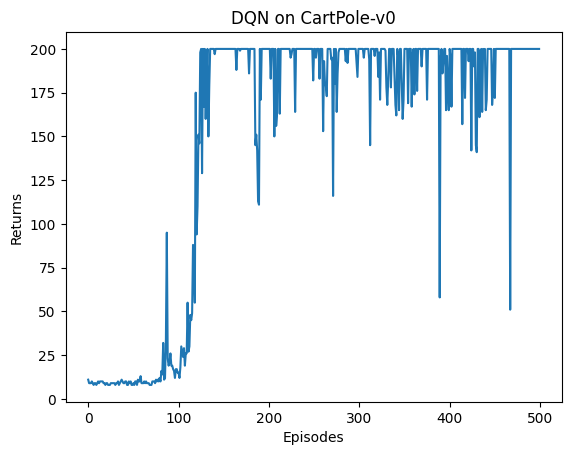

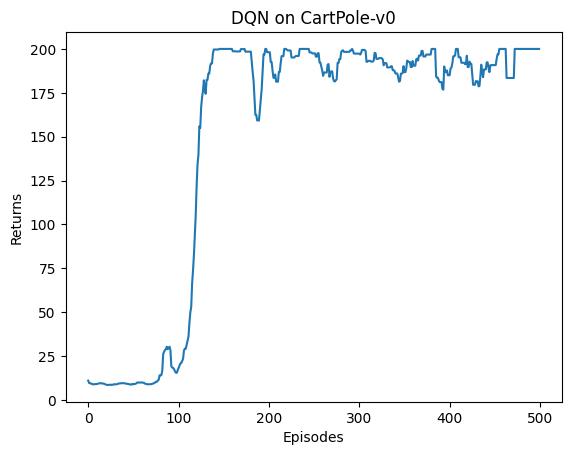

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

- 可以看到，DQN 的性能在 100 个序列后很快得到提升，最终收敛到策略的最优回报值 200。我们也可以看到，在 DQN 的性能得到提升后，它会持续出现一定程度的震荡，这主要是神经网络过拟合到一些局部经验数据后由 $\arg\max$ 运算带来的影响。

## 7.5 以图像为输入的 DQN 算法
- 在本书前面章节所述的强化学习环境中，我们都使用非图像的状态作为输入（例如车杆环境中车的坐标、速度），但是在一些视频游戏中，智能体并不能直接获取这些状态信息，而只能直接获取屏幕中的图像。要让智能体和人一样玩游戏，我们需要让智能体学会以图像作为状态时的决策。我们可以利用 7.4 节的 DQN 算法，将卷积层加入其网络结构以提取图像特征，最终实现以图像为输入的强化学习。以图像为输入的 DQN 算法的代码与 7.4 节的代码的不同之处主要在于 Q 网络的结构和数据输入。DQN 网络通常会将最近的几帧图像一起作为输入，从而感知环境的动态性。接下来我们实现以图像为输入的 DQN 算法，但由于代码需要运行较长的时间，我们在此便不展示训练结果。

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

## 7.6 小结
- 本章讲解了 DQN 算法，其主要思想是用一个神经网络来表示最优策略的函数 $Q$，然后利用 Q-learning 的思想进行参数更新。为了保证训练的稳定性和高效性，DQN 算法引入了经验回放和目标网络两大模块，使得算法在实际应用时能够取得更好的效果。在 2013 年的 NIPS 深度学习研讨会上，DeepMind 公司的研究团队发表了 DQN 论文，首次展示了这一直接通过卷积神经网络接受像素输入来玩转各种雅达利（Atari）游戏的强化学习算法，由此拉开了深度强化学习的序幕。DQN 是深度强化学习的基础，掌握了该算法才算是真正进入了深度强化学习领域，本书中还有更多的深度强化学习算法等待读者探索。